📖 참고 : 텐서플로2와 머신러닝으로 시작하는 자연어 처리

# 텍스트 분류_워드 팝콘
- 워드 팝콘 : 영화 평점 데이터로, 각 데이터는 영화 리뷰 텍스트와 평점에 따른 감정 값으로 구성되어 있다.

## 목표
    1. 데이터 불러오기 및 탐색
    2. 데이터 전처리
    3. 데이터 모델링(로지스틱 회귀, 랜덤포레스트)
    4. 모델 평가
    5. 캐글 제출

-----

#  1. 데이터 불러오기 및 탐색

## 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
%matplotlib inline

## 데이터 압축 풀기

In [2]:
DATA_IN_PATH = './data/word2vec-nlp-tutorial/'

file_list = ['labeledTrainData.tsv.zip', 'unlabeledTrainData.tsv.zip', 'testData.tsv.zip']

for file in file_list:
    zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
    zipRef.extractall(DATA_IN_PATH)
    zipRef.close()

## 데이터 읽기
- sentiment : 긍정(1), 부정(0)

In [3]:
# 항목명 포함, 탭으로 구분, 쌍따옴표 무시
train_data = pd.read_csv(DATA_IN_PATH + "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

In [4]:
train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## 데이터 탐색

### 데이터 크기

In [5]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'tsv' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
labeledTrainData.tsv          33.56MB
testData.tsv                  32.72MB
unlabeledTrainData.tsv        67.28MB


### 데이터 개수

In [6]:
print('전체 학습 데이터의 개수 : {}'.format(len(train_data)))

전체 학습 데이터의 개수 : 25000


### 각 리뷰의 길이 분포

In [7]:
train_length = train_data['review'].apply(len)

train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

c:\users\lovd12\desktop\venv\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of review')

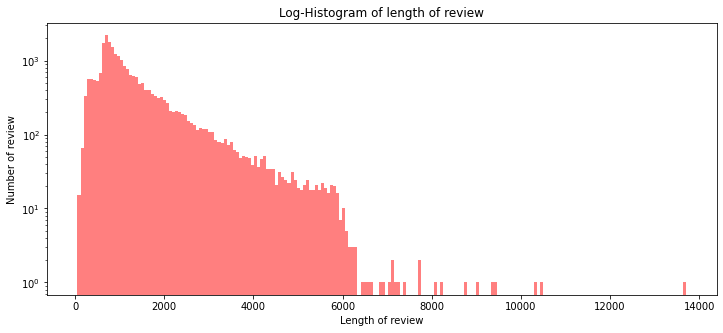

In [8]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip') # nonposy = 'clip' => non-positive 값을 아주 작은 값으로 자름.
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [9]:
print('리뷰 길이 최대 값: {}'.format(np.max(train_length)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

리뷰 길이 최대 값: 13710
리뷰 길이 최소 값: 54
리뷰 길이 평균 값: 1329.71
리뷰 길이 표준편차: 1005.22
리뷰 길이 중간 값: 983.0
리뷰 길이 제 1 사분위: 705.0
리뷰 길이 제 3 사분위: 1619.0


{'whiskers': [<matplotlib.lines.Line2D at 0x240d10c3cc8>,
 'caps': [<matplotlib.lines.Line2D at 0x240d0fa3b48>,
 'boxes': [<matplotlib.lines.Line2D at 0x240cf9ada08>],
 'medians': [<matplotlib.lines.Line2D at 0x240d0f62688>],
 'fliers': [<matplotlib.lines.Line2D at 0x240d0f0c508>],
 'means': [<matplotlib.lines.Line2D at 0x240d13af988>]}

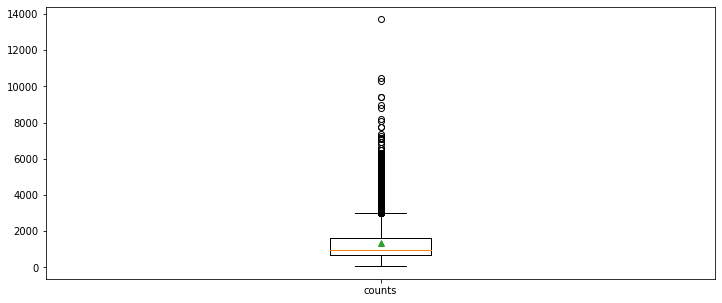

In [10]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['counts'],
             showmeans=True)

### 리뷰에서 많이 사용된 단어 확인

(-0.5, 799.5, 599.5, -0.5)

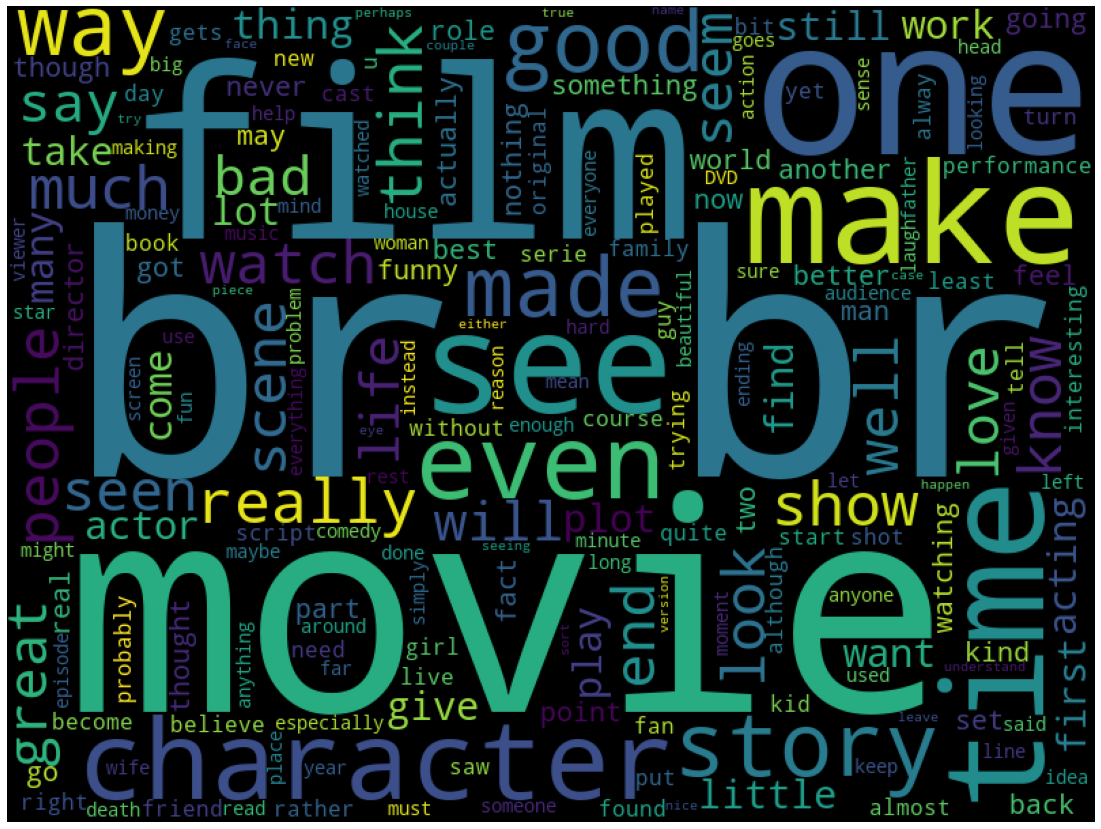

In [11]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_data['review']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

* br 태그 지워야 함 => 전처리 과정에서 진행

### 각 라벨(긍, 부정 데이터)의 분포 확인

c:\users\lovd12\desktop\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

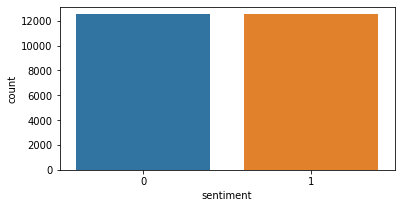

In [12]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['sentiment'])

In [13]:
print("긍정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[0]))

긍정 리뷰 개수: 12500
부정 리뷰 개수: 12500


### 각 리뷰당 단어 개수 확인

In [14]:
train_word_counts = train_data['review'].apply(lambda x:len(x.split(' ')))

c:\users\lovd12\desktop\venv\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Number of reviews')

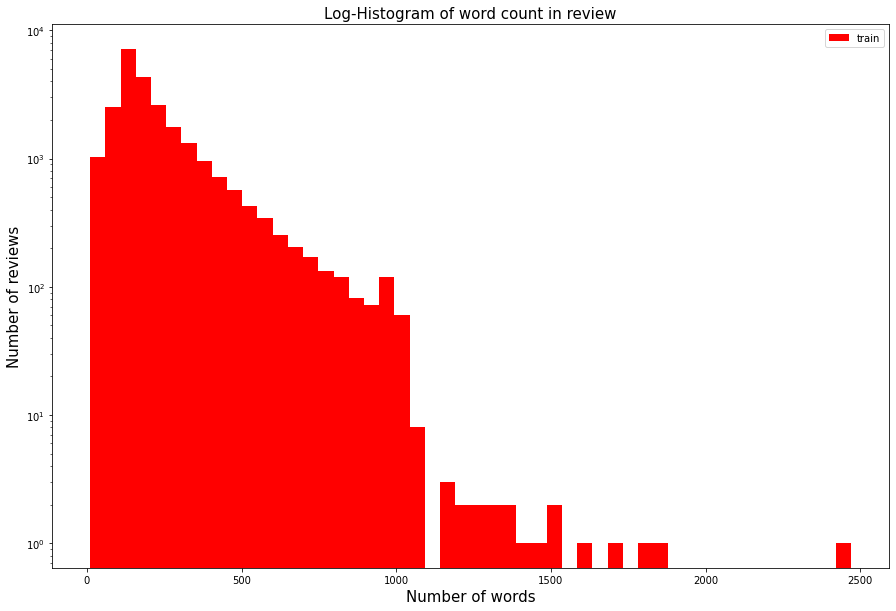

In [15]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [16]:
print('리뷰 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최대 값: 2470
리뷰 단어 개수 최소 값: 10
리뷰 단어 개수 평균 값: 233.79
리뷰 단어 개수 표준편차: 173.74
리뷰 단어 개수 중간 값: 174.0
리뷰 단어 개수 제 1 사분위: 127.0
리뷰 단어 개수 제 3 사분위: 284.0


### 특수문자 및 대, 소문자 비율

In [17]:
qmarks = np.mean(train_data['review'].apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['review'].apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_data['review'].apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_data['review'].apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_data['review'].apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 질문: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 질문: {:.2f}%'.format(capitals * 100))
print('숫자가있는 질문: {:.2f}%'.format(numbers * 100))

물음표가있는 질문: 29.55%
마침표가 있는 질문: 99.69%
첫 글자가 대문자 인 질문: 0.00%
대문자가있는 질문: 99.59%
숫자가있는 질문: 56.66%


## 2. 데이터 전처리

In [18]:
import re # 데이터 정제
import json
from bs4 import BeautifulSoup # 데이터 정제
from nltk.corpus import stopwords # 불용어 제거
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [19]:
DATA_IN_PATH = './data/word2vec-nlp-tutorial/'

train_data = pd.read_csv(DATA_IN_PATH + "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
print(train_data['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

### HTML 태그, 특수문자 제거

In [20]:
review = train_data['review'][0]
review_text = BeautifulSoup(review, "html.parser").get_text() # HTML 태그 제거
review_text = re.sub("[^a-zA-Z]", " ", review_text) # 영어 문자를 제외한 나머지는 모두 공백으로 바꿈

print(review_text)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

### 불용어(stopword) 삭제

불용어란? 문장에서 자주 출현하나 전체적인 의미에 큰 영향을 주지 않는 단어

In [21]:
stop_words = set(stopwords.words('english'))

review_text = review_text.lower()
words = review_text.split()
words = [w for w in words if not w in stop_words]

In [22]:
clean_review = ' '.join(words)
print(clean_review)

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

함수로 정리

In [23]:
def preprocessing(review, remove_stopwords = False):
    review_text = BeautifulSoup(review, "html.parser").get_text()
    
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    
    words = review_text.lower().split()
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        clean_review = ' '.join(words)
        
    else:
        clean_review = ' '.join(words)
        
    return clean_review

In [24]:
clean_train_reviews = []
for review in train_data['review']:
    clean_train_reviews.append(preprocessing(review, remove_stopwords = True))
    
clean_train_reviews[10]

'happens army wetbacks towelheads godless eastern european commies gather forces south border gary busey kicks butts course another laughable example reagan era cultural fallout bulletproof wastes decent supporting cast headed l q jones thalmus rasulala'

###  벡터화

모델에 따라 각 리뷰가 단어들의 인덱스로 구성된 벡터가 아닌 텍스트로 구성돼야 하는 경우가 있음  
-> 전처리한 데이터를 판다스의 데이터프레임으로 만들어둠

In [25]:
clean_train_df = pd.DataFrame({'review': clean_train_reviews, 'sentiment': train_data['sentiment']})

Tokenizer 모듈을 생성한 후 정제된 데이터에 적용하고 인덱스로 구성된 벡터로 변환

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)

print(text_sequences[0]) # 인덱스의 벡터로 구성

[404, 70, 419, 8815, 506, 2456, 115, 54, 873, 516, 178, 18686, 178, 11242, 165, 78, 14, 662, 2457, 117, 92, 10, 499, 4074, 165, 22, 210, 581, 2333, 1194, 11242, 71, 4826, 71, 635, 2, 253, 70, 11, 302, 1663, 486, 1144, 3265, 8815, 411, 793, 3342, 17, 441, 600, 1500, 15, 4424, 1851, 998, 146, 342, 1442, 743, 2424, 4, 8815, 418, 70, 637, 69, 237, 94, 541, 8815, 26055, 26056, 120, 1, 8815, 323, 8, 47, 20, 323, 167, 10, 207, 633, 635, 2, 116, 291, 382, 121, 15535, 3315, 1501, 574, 734, 10013, 923, 11578, 822, 1239, 1408, 360, 8815, 221, 15, 576, 8815, 22224, 2274, 13426, 734, 10013, 27, 28606, 340, 16, 41, 18687, 1500, 388, 11243, 165, 3962, 8815, 115, 627, 499, 79, 4, 8815, 1430, 380, 2163, 114, 1919, 2503, 574, 17, 60, 100, 4875, 5100, 260, 1268, 26057, 15, 574, 493, 744, 637, 631, 3, 394, 164, 446, 114, 615, 3266, 1160, 684, 48, 1175, 224, 1, 16, 4, 8815, 3, 507, 62, 25, 16, 640, 133, 231, 95, 7426, 600, 3439, 8815, 37248, 1864, 1, 128, 342, 1442, 247, 3, 865, 16, 42, 1487, 997, 2333, 12

In [27]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

In [28]:
print("전체 단어 개수: ", len(word_vocab))

전체 단어 개수:  74066


In [29]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

### 패딩

현재 각 데이터는 서로 길이가 다른데 이 길이를 하나로 통일해야 이후 모델에 바로 적용할 수 있음  
-> 특정 길이를 최대 길이로 정하고 더 긴 데이터의 경우 뒷부분을 자르고 짧은 데이터의 경우에는 0 값으로 패딩하는 작업을 진행

In [30]:
MAX_SEQUENCE_LENGTH = 174 

train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # padding은 0값을 앞에? 뒤에?

print('Shape of train data: ', train_inputs.shape)

Shape of train data:  (25000, 174)


### 라벨을 넘파이 배열로 저장

In [31]:
train_labels = np.array(train_data['sentiment'])
print('Shape of label tensor:', train_labels.shape)

Shape of label tensor: (25000,)


### 전처리한 데이터 저장

In [32]:
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [33]:
# 전처리 된 데이터를 넘파이 형태로 저장, 딥러닝 모델에서 사용
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs) # 벡터화한 데이터
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels) # 정답 라벨

# 정제된 텍스트를 csv 형태로 저장, 머신러닝 모델에서 사용
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index = False)

# 데이터 사전을 json 형태로 저장, 딥러닝 모델에서 사용
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

### 평가 데이터 전처리

In [34]:
test_data = pd.read_csv(DATA_IN_PATH + "testData.tsv", header=0, delimiter="\t", quoting=3)

clean_test_reviews = []
for review in test_data['review']:
    clean_test_reviews.append(preprocessing(review, remove_stopwords = True))

clean_test_df = pd.DataFrame({'review': clean_test_reviews, 'id': test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews) # 기존에 학습 데이터에 적용한 토크나이저 객체 사용(why? 인덱스가 달라지므로)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [35]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)

-------

## 3. 데이터 모델링(Logistic Regression with TF-IDF)

TfidfVectorizer를 사용하기 위해서는 입력값이 텍스트로 이러진 데이터 형태여야함

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
TRAIN_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv( DATA_IN_PATH + TRAIN_CLEAN_DATA )

In [38]:
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

### TF-IDF 벡터화

In [39]:
# mindf : 설정한 값보다 특정 토큰의 df 값이 더 적게 나오면 벡터화 과정에서 제거
# analyzer : 분석하기 위한 기준 단위
# sublinear_tf : 문서의 단어 빈도수에 대한 스무딩 여부를 설정하는 값
# ngram_range : 빈도의 기본 단위를 어느 범위의 n-gram으로 설정할 것인지를 보는 인자
# max_features : 각 벡터의 최대 길이, 특징의 길이를 설정하는 것
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_features=5000) 

X = vectorizer.fit_transform(reviews)
y = np.array(sentiments)

### 학습과 검증 데이터셋 분리

In [40]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

### 모델 학습

In [41]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced') # 각 레벨에 대해 균형 있에 학습할 수 있게 한다
lgs.fit(X_train, y_train) 

LogisticRegression(class_weight='balanced')

## 4. 모델 평가

### 검증 데이터로 성능 평가

In [42]:
print("Accuracy: %f" % lgs.score(X_eval, y_eval))

Accuracy: 0.859800


## 5. 캐글 제출

In [43]:
TEST_CLEAN_DATA = 'test_clean.csv'

test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)

In [44]:
testDataVecs = vectorizer.transform(test_data['review'])

In [45]:
test_predicted = lgs.predict(testDataVecs)
print(test_predicted)

[1 0 1 ... 0 1 0]


In [46]:
DATA_OUT_PATH = './data/word2vec-nlp-tutorial/data_out/'

In [47]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

answer_dataset = pd.DataFrame({'id': test_data['id'], 'sentiment': test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_tfidf_answer.csv', index=False, quoting=3)

### 📌 점수 : 0.85384

------

## 3. 데이터 모델링(Logistic Regression Example with Word2Vec)

word2vec의 경우 단어로 표현된 리스트를 입력값으로 넣어야 하기 때문에 전처리한 넘파이 배열 사용x

In [48]:
TRAIN_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA)

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

In [49]:
sentences = []
for review in reviews:
    sentences.append(review.split())

### word2vec 벡터화

In [50]:
# 학습 시 필요한 하이퍼파라미터
num_features = 300 # 워드 벡터 특징값 수
min_word_count = 40 # 단어에 대한 최소 빈도 수
num_workers = 4 # 프로세스 개수
context = 10 # 컨텍스트 윈도 크기
downsampling = 1e-3 # 다운 샘플링 비율

In [51]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
   level=logging.INFO)

In [52]:
from gensim.models import word2vec

model = word2vec.Word2Vec(sentences, workers=num_workers, \
           size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

2021-02-16 12:44:51,295 : INFO : collecting all words and their counts
2021-02-16 12:44:51,297 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-16 12:44:51,720 : INFO : PROGRESS: at sentence #10000, processed 1205223 words, keeping 51374 word types
2021-02-16 12:44:52,089 : INFO : PROGRESS: at sentence #20000, processed 2396605 words, keeping 67660 word types
2021-02-16 12:44:52,300 : INFO : collected 74065 word types from a corpus of 2988089 raw words and 25000 sentences
2021-02-16 12:44:52,300 : INFO : Loading a fresh vocabulary
2021-02-16 12:44:52,344 : INFO : effective_min_count=40 retains 8160 unique words (11% of original 74065, drops 65905)
2021-02-16 12:44:52,346 : INFO : effective_min_count=40 leaves 2627273 word corpus (87% of original 2988089, drops 360816)
2021-02-16 12:44:52,386 : INFO : deleting the raw counts dictionary of 74065 items
2021-02-16 12:44:52,391 : INFO : sample=0.001 downsamples 30 most-common words
2021-02-16 12:44:52,392 :

### 같은 형태의 입력값으로 만들기(Why? 리뷰마다 단어의 개수가 모두 다름)

하나의 리뷰에 대해 전체 단어의 평균값을 계산하는 함수

In [53]:
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features),dtype=np.float32)

    num_words = 0
    index2word_set = set(model.wv.index2word)

    for w in words:
        if w in index2word_set:
            num_words += 1
            feature_vector = np.add(feature_vector, model[w])

    feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

전체 리뷰에 대해 각 리뷰의 평균 벡터를 구하는 함수

In [54]:
def get_dataset(reviews, model, num_features):
    dataset = list()

    for s in reviews:
        dataset.append(get_features(s, model, num_features))

    reviewFeatureVecs = np.stack(dataset)
    
    return reviewFeatureVecs

In [55]:
test_data_vecs = get_dataset(sentences, model, num_features)

test_data_vecs

c:\users\lovd12\desktop\venv\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


array([[ 0.34526697,  0.10090645, -0.07440904, ...,  0.00587434,
         0.10258691,  0.1649957 ],
       [ 0.33918276, -0.13932413,  0.08508542, ...,  0.2684362 ,
        -0.01413368,  0.15134874],
       [ 0.03515865,  0.05553856,  0.05138972, ...,  0.06277017,
         0.044056  ,  0.02914383],
       ...,
       [ 0.16389889, -0.04916835, -0.07019078, ..., -0.02183763,
         0.22759522,  0.19199865],
       [ 0.23570521,  0.0447161 , -0.09558295, ..., -0.06316429,
        -0.03415726,  0.06794731],
       [ 0.33698276, -0.04673762, -0.19597584, ...,  0.08735377,
        -0.0025575 ,  0.02529707]], dtype=float32)

### 학습과 검증 데이터셋 분리

In [56]:
X = test_data_vecs
y = np.array(sentiments)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

### 모델 학습

In [57]:
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

c:\users\lovd12\desktop\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

## 4. 모델 평가

### 검증 데이터셋으로 성능 평가

In [58]:
print("Accuracy: %f" % lgs.score(X_test, y_test))

Accuracy: 0.863200


## 5. 캐글 제출

In [59]:
TEST_CLEAN_DATA = 'test_clean.csv'

test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)

test_review = list(test_data['review'])

In [60]:
test_sentences = list()
for review in test_review:
    test_sentences.append(review.split())

In [61]:
test_data_vecs = get_dataset(test_sentences, model, num_features)

c:\users\lovd12\desktop\venv\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [62]:
test_predicted = lgs.predict(test_data_vecs)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
i### 📌 점수 : 0.85384ds = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment': test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_w2v_answer.csv', index=False, quoting=3)

### 📌 점수 : 0.85632

## 모델 저장

In [63]:
model_name = "300features_40minwords_10context"
model.save(model_name)

2021-02-16 12:46:10,457 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2021-02-16 12:46:10,458 : INFO : not storing attribute vectors_norm
2021-02-16 12:46:10,460 : INFO : not storing attribute cum_table
2021-02-16 12:46:10,645 : INFO : saved 300features_40minwords_10context


-----------

## 3. 데이터 모델링(Random Forest)

### CountVetorizer를 활용한 벡터화

전처리한 텍스트 데이터를 입력값으로 사용해야 함

In [64]:
TRAIN_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA)

reviews = list(train_data['review'])
y = np.array(train_data['sentiment'])

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", max_features = 5000) 

train_data_features = vectorizer.fit_transform(reviews)

### 학습과 검증 데이터 분리

In [66]:
TEST_SIZE = 0.2
RANDOM_SEED = 42

train_input, eval_input, train_label, eval_label = train_test_split(train_data_features, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

### 모델 학습

In [67]:
from sklearn.ensemble import RandomForestClassifier


# 랜덤 포레스트 분류기에 100개 의사 결정 트리를 사용한다.
forest = RandomForestClassifier(n_estimators = 100) 

# 단어 묶음을 벡터화한 데이터와 정답 데이터를 가지고 학습을 시작한다.
forest.fit(train_input, train_label)

RandomForestClassifier()

## 4. 모델 평가

### 검증 데이터셋으로 성능 평가

In [68]:
print("Accuracy: %f" % forest.score(eval_input, eval_label))

Accuracy: 0.843600


## 5. 캐글 제출

In [69]:
TEST_CLEAN_DATA = 'test_clean.csv'

test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)

test_reviews = list(test_data['review'])
ids = list(test_data['id'])

In [70]:
test_data_features = vectorizer.transform(test_reviews)

In [71]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
result = forest.predict(test_data_features)

output = pd.DataFrame( data={"id": ids, "sentiment": result} )

output.to_csv( DATA_OUT_PATH + "Bag_of_Words_model.csv", index=False, quoting=3 )

### 📌 점수 : 0.84408